# Using ColPali with Qdrant to index and search a UFO document dataset

Based on: https://danielvanstrien.xyz/posts/post-with-code/colpali-qdrant/2024-10-02_using_colpali_with_qdrant.html

In [1]:
import os
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

In [2]:
dataset = load_dataset("davanstrien/ufo-ColPali", split="train")

In [3]:
dataset

Dataset({
    features: ['image', 'raw_queries', 'broad_topical_query', 'broad_topical_explanation', 'specific_detail_query', 'specific_detail_explanation', 'visual_element_query', 'visual_element_explanation', 'parsed_into_json'],
    num_rows: 2243
})

In [4]:
# Trim the dataset to the first 200 rows
dataset = dataset.select(range(200))

# Verify the new size
print(f"Dataset size after trimming: {len(dataset)}")



Dataset size after trimming: 200


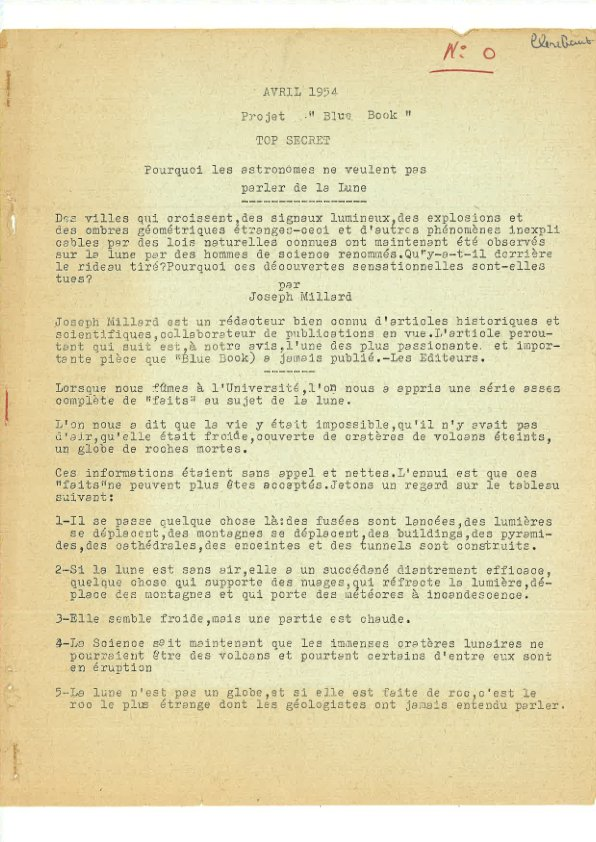

In [5]:
dataset[0]["image"]



In [6]:
qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage

In [7]:
from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "davanstrien/finetune_colpali_v1_2-ufo-4bit"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
sample_image = dataset[0]["image"]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [9]:
sample_embedding

tensor([[[ 0.0181, -0.0082,  0.1455,  ...,  0.0118, -0.0859, -0.1670],
         [-0.0223,  0.1777,  0.1709,  ...,  0.0234, -0.1104, -0.1191],
         [ 0.0623,  0.1602,  0.0869,  ..., -0.0488, -0.0269, -0.0510],
         ...,
         [-0.0649, -0.0114,  0.1660,  ..., -0.0820,  0.0693,  0.0408],
         [-0.1235,  0.1079,  0.1855,  ...,  0.0312, -0.0527, -0.0688],
         [-0.0732,  0.1118,  0.2236,  ...,  0.0186, -0.0649, -0.0874]]],
       device='mps:0', dtype=torch.bfloat16)

In [10]:
sample_embedding.shape

torch.Size([1, 1030, 128])

In [11]:
vector_size = sample_embedding.shape[2]
vector_size

128

In [12]:
import os

# Set the environment variable
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.9'

# Print confirmation message
print(f"PYTORCH_MPS_HIGH_WATERMARK_RATIO set to: {os.environ.get('PYTORCH_MPS_HIGH_WATERMARK_RATIO', 'Not set')}")


PYTORCH_MPS_HIGH_WATERMARK_RATIO set to: 0.9


In [13]:
collection_name = "ufo"

In [14]:
vector_params = models.VectorParams(
    size=vector_size,
    distance=models.Distance.COSINE,
    multivector_config=models.MultiVectorConfig(
        comparator=models.MultiVectorComparator.MAX_SIM
    ),
)

In [15]:
print(vector_params)

size=128 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)


In [16]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8,
    quantile=0.99,
    always_ram=False,
)

In [17]:
qdrant_client.recreate_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                quantile=0.99,
                always_ram=True,
            ),
        ),
    ),
)

/var/folders/3s/xftgktnj6qs681vbh0tg5hmc0000gn/T/ipykernel_9305/170624471.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

In [18]:
import stamina


@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [19]:
batch_size = 2  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )
        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        # clown level error handling here 🤡
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 100%|██████████| 200/200 [23:10<00:00,  6.95s/it]

Indexing complete!


In [20]:
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

False

In [21]:
from rich import print as r_print

collection = qdrant_client.get_collection(collection_name)
r_print(collection)

CollectionInfo(
    status=<CollectionStatus.GREEN: 'green'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=None,
    indexed_vectors_count=0,
    points_count=200,
    segments_count=1,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=128,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=ScalarQuantization(
                    scalar=ScalarQuantizationConfig(
                        type=<ScalarType.INT8: 'int8'>,
                        quantile=0.99,
                        always_ram=True
                    )
                ),
                on_disk=None,
                datatype=None,
                multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
            ),
            shard_number=None,
            sharding_method=None,
            replication_factor=None,
            write_consistency_factor=None,
            read_fan_out_factor=None,
            on_disk_payload=None,
            sparse_vectors=None
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=None,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=20000,
            flush_interval_sec=5,
            max_optimization_threads=1
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None
    ),
    payload_schema={}
)

In [22]:
qdrant_client.scroll(collection_name=collection_name, limit=10)

([Record(id=0, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=5, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=6, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=7, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=8, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=9, payload={'source': 'internet archive'}, vector=None, shard

In [23]:
query_text = "top secret"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 0.1553, -0.0203,  0.0859,  ..., -0.0212, -0.0718, -0.0332],
         [-0.0962, -0.1074,  0.0486,  ..., -0.0118, -0.0972,  0.0776],
         [-0.1206, -0.0461,  0.0530,  ..., -0.0078,  0.0009, -0.0173],
         ...,
         [-0.0557,  0.0305,  0.0347,  ...,  0.0192,  0.0537,  0.0532],
         [-0.0601,  0.0398,  0.0327,  ...,  0.0109,  0.0415,  0.0405],
         [-0.0366,  0.0605,  0.0537,  ..., -0.0032,  0.0415,  0.0208]]],
       device='mps:0', dtype=torch.bfloat16)

In [24]:
query_embedding[0].shape

torch.Size([16, 128])

In [26]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [27]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=10, timeout=60
)

search_result.points

[ScoredPoint(id=0, version=0, score=11.050991319043229, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=65, version=0, score=9.100512322978444, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=177, version=0, score=8.978563997267173, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=171, version=0, score=8.708889722892284, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=59, version=0, score=8.390979433229916, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=47, version=0, score=8.361775979675869, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=174, version=0, score=7.588643950559245, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_va

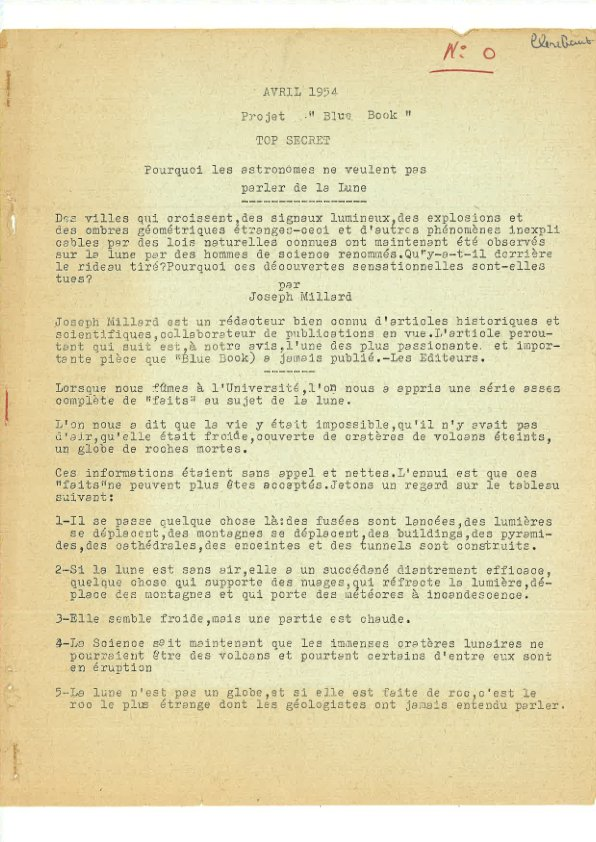

In [28]:
idx = search_result.points[0].id
dataset[idx]["image"]

In [29]:
def search_images_by_text(query_text, top_k=5):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, limit=top_k
    )

    return search_result


# Example usage
query_text = "declassified data"
results = search_images_by_text(query_text)

for result in results.points:
    print(result)

id=65 version=0 score=12.166231494684622 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=67 version=0 score=12.00896150097188 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=64 version=0 score=11.144427569892274 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=40 version=0 score=10.92592059204144 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=59 version=0 score=10.556421434761935 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None


In [30]:
def search_by_text_and_return_images(query_text, top_k=5):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return dataset.select(row_ids)

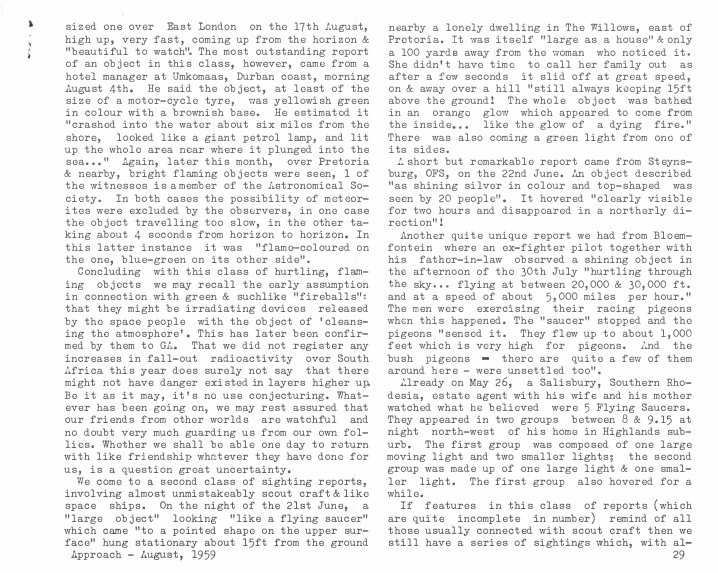

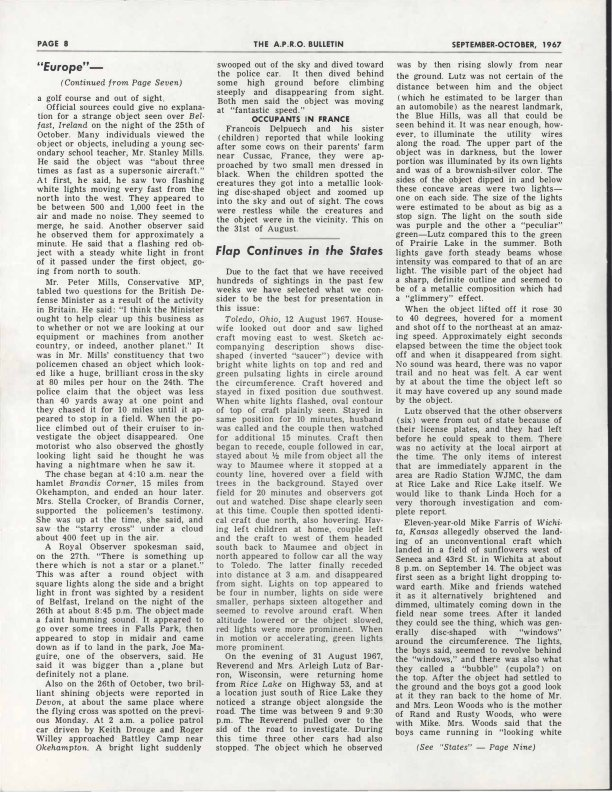

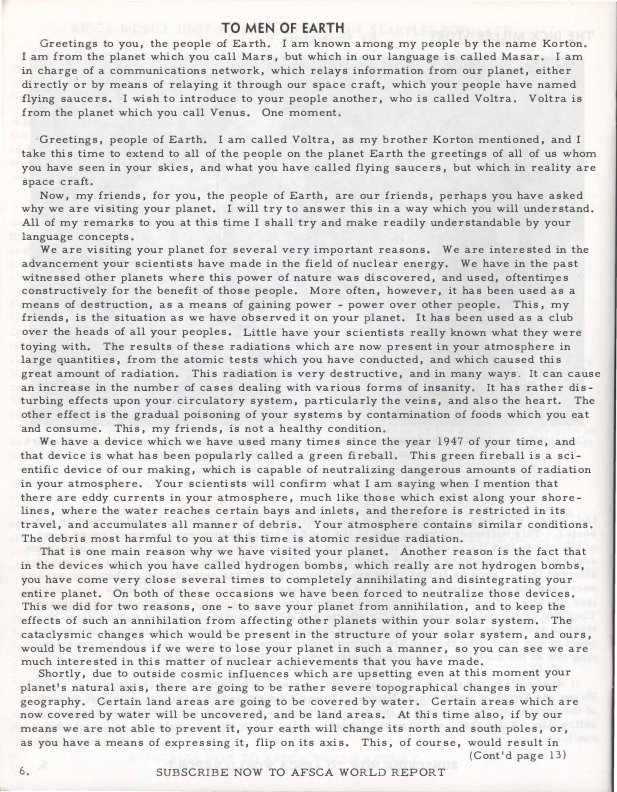

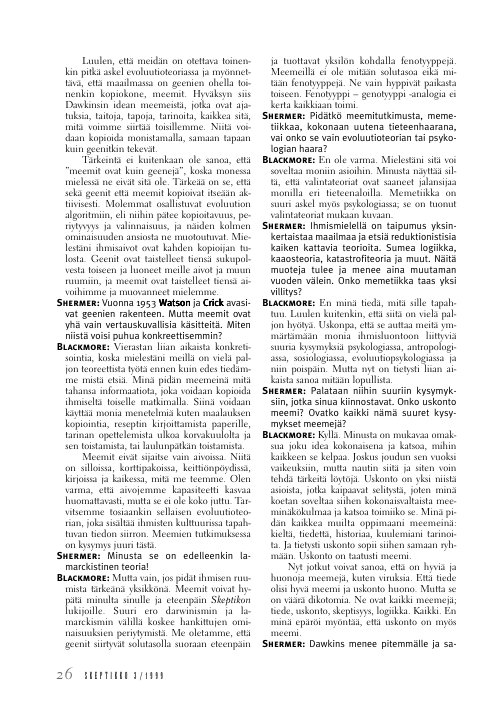

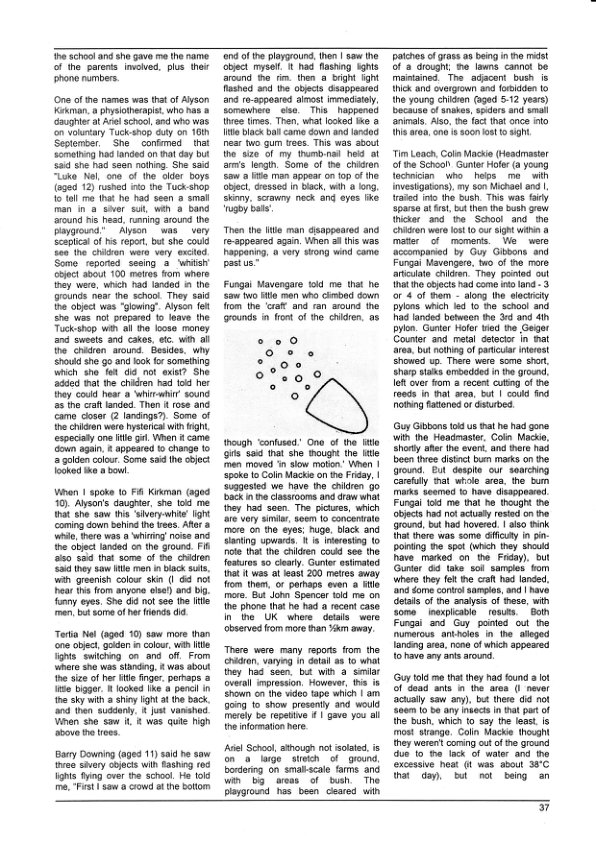

In [31]:
results_ds = search_by_text_and_return_images("green people")

for row in results_ds:
    # display image
    display(row["image"])